# Lecture03

## Ensemble methods

### CIS432 Machine Learning for Business Analytics


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
# Load and visualize a dataset
heart=pd.read_csv('https://drive.google.com/uc?id=1btzJVMmgdciBySEVZtyp_TEyXfgpLxeV&export=download', index_col=0)
heart=heart.dropna()
print(heart.shape)
heart.head()

(297, 14)


,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [ ]:
# Assume the dataframe contains the train data and conduct simple pre-processing
heart['AHD']=(heart['AHD']=='Yes').astype(int)
df_thal = pd.get_dummies(heart['Thal'],prefix='Thal')
heart = pd.concat([heart, df_thal], axis=1)
heart = pd.concat([heart, pd.get_dummies(heart['ChestPain'],prefix='ChestPain')], axis=1)
X_labels = [c for c in heart.columns if c not in ['AHD','Thal','ChestPain']]
X = heart.loc[:,X_labels]
Y = heart['AHD']

### Fit bootstrap aggregation (Bagging) of decision trees of depth 1

In [ ]:
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

# initialize a base classifier (decision tree of depth 1)
base_clf = tree.DecisionTreeClassifier(max_depth=1)

# create a bagging model (specify hyper parameters)
clf = BaggingClassifier(n_estimators=50, estimator=base_clf, oob_score=True)

# bootstrap and train 50 models
clf = clf.fit(X,Y)

# report OOB error (using 50 trained trees)
print('OOB:%.3f'% clf.oob_score_)

# compute CV error (using 50x5 trees)
scores = cross_val_score(clf, X, Y, cv=5)
print('CV: %.3f (mean) %.3f (std)'%(scores.mean(),scores.std()))

OOB:0.778
CV: 0.770 (mean) 0.092 (std)


### OOB vs. CV estimation


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_bagging.py:865: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_bagging.py:871: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_bagging.py:865: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_bagging.py:871: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_bagging.py:865: UserWarning: Some inputs do not have OOB scores. This probably means too few e

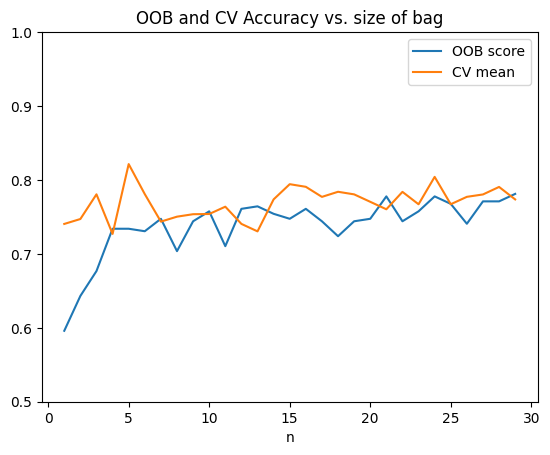

In [ ]:
### Train ensembles of 1-30 trees and evaluate performance
base_clf = tree.DecisionTreeClassifier(max_depth=1)
results = []
for n in range(1,30,1):
    clf = BaggingClassifier(n_estimators=n, estimator=base_clf, oob_score=True)
    clf = clf.fit(X,Y)
    scores = cross_val_score(clf, X, Y, cv=5)
    results.append((n,scores.mean(), scores.std(),clf.oob_score_))

df_bagging_errors = pd.DataFrame(data=results,columns=['n','CV mean','CV std','OOB score'])

fig, ax = plt.subplots()
df_bagging_errors.plot(x='n',y='OOB score',ylim=[0.5,1],ax=ax)
df_bagging_errors.plot(x='n',y='CV mean',ylim=[0.5,1],ax=ax)
plt.title('OOB and CV Accuracy vs. size of bag');

Observations about OOB error:
* OOB error is not accurate for small ensembles
* Generally improves but still random

Observations about Bagging:
* Do not tend to overfit
* Running time will increase with the size of the ensemble

### Training Random Forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_features="sqrt", n_estimators=30, max_depth=1)
clf_rf_scores = cross_val_score(clf_rf, X, Y, cv=5)
print('Average accuracy', clf_rf_scores.mean())

Average accuracy 0.8346892655367231


In [ ]:
clf_rf.fit(X,Y)

RandomForestClassifier(max_depth=1, n_estimators=30)

[0.03333333 0.03333333 0.         0.         0.         0.
 0.13333333 0.06666667 0.13333333 0.06666667 0.16666667 0.
 0.06666667 0.13333333 0.13333333 0.         0.03333333 0.        ]


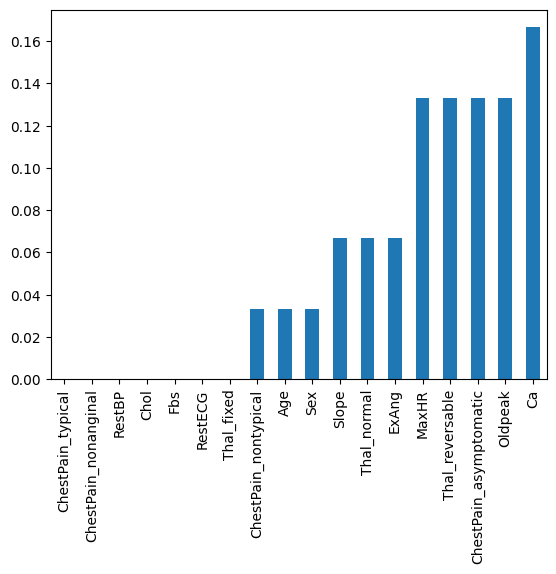

In [ ]:
# print feature importance
print(clf_rf.feature_importances_)

# plot feature importance as a bar plot
pd.Series(data=clf_rf.feature_importances_, index=X.columns).sort_values().plot.bar();

### Train a boosting model

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf = clf.fit(X,Y)
print('AdaBoost train accuracy:', clf.score(X,Y))

AdaBoost train accuracy: 0.8821548821548821


### Comparison - single tree, Bagging, RF, Boosting

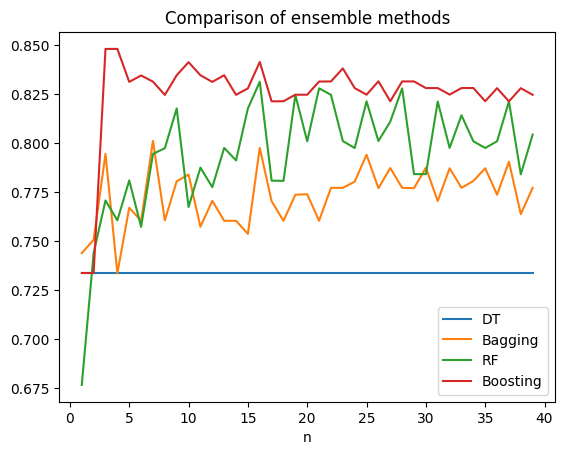

In [ ]:
# baseline - a single DT
tree_depth = 1
clf_tree = tree.DecisionTreeClassifier(max_depth=tree_depth)
clf_tree_scores = cross_val_score(clf_tree, X, Y, cv=5)


base_clf = tree.DecisionTreeClassifier(max_depth=tree_depth) # base classifier
results = []

for n in range(1,40,1):
    # bagging with n bootstrapped data sets
    clf_bagging = BaggingClassifier(n_estimators=n, estimator=base_clf)
    clf_bagging_scores = cross_val_score(clf_bagging, X, Y, cv=5)

    # RF with n bootstrapped data sets m=sqrt(p)
    clf_rf = RandomForestClassifier(max_features="sqrt", n_estimators=n, max_depth=tree_depth)
    clf_rf_scores = cross_val_score(clf_rf, X, Y, cv=5)

    # Boosting with n bootstrapped data sets m=sqrt(p)
    clf_boosting = AdaBoostClassifier(n_estimators=n, learning_rate=0.5)
    clf_boosting_scores = cross_val_score(clf_boosting, X, Y, cv=5)

    results.append({'n':n,
                    'DT':clf_tree_scores.mean(),
                    'Bagging':clf_bagging_scores.mean(),
                    'RF':clf_rf_scores.mean(),
                    'Boosting':clf_boosting_scores.mean()
                    })

df_comparison = pd.DataFrame(data=results)
df_comparison.plot(x='n', y=['DT','Bagging','RF','Boosting'])
plt.legend(loc='lower right')
plt.title('Comparison of ensemble methods');

Observations
* Improved performance of ensembles over a single DT
* Bagging (and RF) improve until plateau
  - They do not tend to overfit
* Boosting overfits when the ensemble size is too large

Return to presentation